In [1]:
# Basic building-block packages
import numpy as np
from numpy import heaviside as th

# For numerical solutions of ODEs
from scipy.integrate import solve_ivp

# Some fancy-smancy maths!! (not really)
from scipy.stats import linregress
from numpy.linalg import norm

# For pretty-pretty graphs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Quality of life shit
from tqdm import tqdm
import pickle

import scipy.fftpack as fft



def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

def sys_DE(t,w,inte,exte,circ):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x,y,z = w
    R,C1,C2,L,F,freq = circ
    dx = ((y-x)/R-Chua(x,*inte,*exte))/C1
    dy = ((x-y)/R+z)/C2
    dz = -y/L-(F*np.sin(2*np.pi*freq*t))/L
    return dx,dy,dz

def standardise(x,y,z,t,step=1):
    z = ((z[:-1]-z[1:])/(t[:-1]-t[1:])*L)[::step]
    x = x[1::step]
    y = y[1::step]
    t = t[1::step]
    return x,y,z,t

def max_lyapunov(X1,X2):
    X1_0,X2_0 = X1[0],X2[0]

    dX = [x1-x2 for x1,x2 in zip(X1,X2)]
    dX = np.linalg.norm(dX,axis=0)

    dX0 = [X1-X2 for X1,X2 in zip(X1_0,X2_0)]
    dX0 = np.linalg.norm(dX0)

    y = dX/dX0
    t = data[0][3]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue
    return m,b,corr

## Bif for Lorenz System

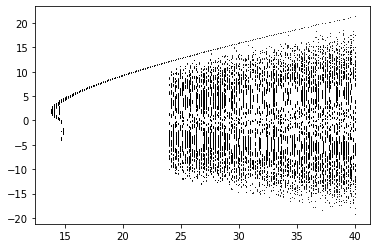

In [45]:
def sys_DE(t,w,sigma,rho,beta):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
    """
    x,y,z = w
    dx = sigma*(y-x)
    dy = x*(rho-z)-y
    dz = x*y-beta*z
    return dx,dy,dz

t_span = (0,50)
t_eval = np.linspace(*t_span,int(1e5)) # No need to be so fine like here. 
xyz0 = [2,1,1] # Recall that z is in Amperes (a large unit).

sigma = np.linspace(10, 40, 200)

# Function to collect x at y=0
def find_x_zeros(x, y, eps): return x[np.abs(y)<eps]
x_intercepts = []
eps = 1e-1

for s in tqdm(sigma, leave=False):
    
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                         args=[10,s,8/3])

    x_sol = solution.y[0]
    y_sol = solution.y[1]
    z_sol = solution.y[2]

    # Finding Vx at Vy=0
    x_intercepts.append(find_x_zeros(x_sol, y_sol, eps))

# Plotting
for i in range(len(sigma)):
    plt.plot(sigma[i]*np.ones(len(x_intercepts[i])), x_intercepts[i], 'o', color='k', markersize=1, markeredgecolor='none')

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [03:26<00:00,  7.75it/s]


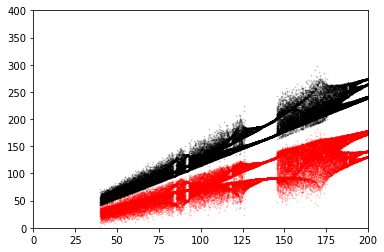

In [44]:
import numpy as np
import matplotlib.pyplot as plt


def lorenz_system(x, y, z, r, s=10, b=8/3):
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot


r = 1  # parameter step size
r = np.arange(40, 200, dr)  # parameter range
dt = 0.001  # time step
t = np.arange(0, 10, dt)  # time range

# initialize solution arrays
xs = np.empty(len(t) + 1)
ys = np.empty(len(t) + 1)
zs = np.empty(len(t) + 1)

# initial values x0,y0,z0 for the system
xs[0], ys[0], zs[0] = (1, 1, 1)


# Save the plot points coordinates and plot the with a single call to plt.plot
# instead of plotting them one at a time, as it's much more efficient
r_maxes = []
z_maxes = []
r_mins = []
z_mins = []


for R in tqdm(r):
    for i in range(len(t)):
        # approximate numerical solutions to system
        x_dot, y_dot, z_dot = lorenz_system(xs[i], ys[i], zs[i], R)
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
    # calculate and save the peak values of the z solution
    for i in range(1, len(zs) - 1):
        # save the local maxima
        if zs[i - 1] < zs[i] and zs[i] > zs[i + 1]:
            r_maxes.append(R)
            z_maxes.append(zs[i])
        # save the local minima
        elif zs[i - 1] > zs[i] and zs[i] < zs[i + 1]:
            r_mins.append(R)
            z_mins.append(zs[i])

    # "use final values from one run as initial conditions for the next to stay near the attractor"
    xs[0], ys[0], zs[0] = xs[i], ys[i], zs[i]


plt.scatter(r_maxes, z_maxes, color="black", s=0.5, alpha=0.2)
plt.scatter(r_mins, z_mins, color="red", s=0.5, alpha=0.2)

plt.xlim(0, 200)
plt.ylim(0, 400)
plt.show()

## Fast Fourier Transform

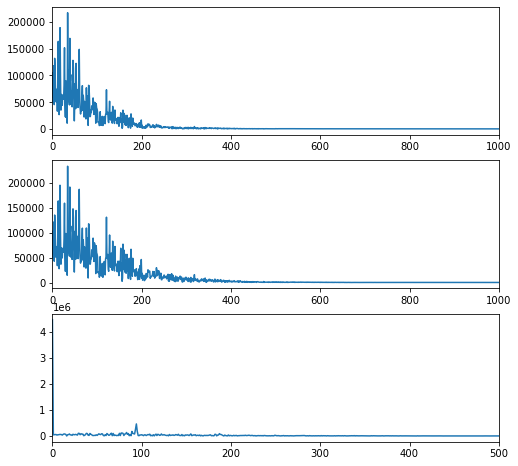

In [106]:
# sample spacing

Xf = fft.fft(x_sol)
Yf = fft.fft(y_sol)
Zf = fft.fft(z_sol)

samp = 1e5
tau = 1/samp # time interval

freq = fft.fftfreq(len(x_sol), tau)

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(3,1,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[1,0])
axs3 = plt.subplot(grid[2,0])

axs1.set_xlim(left=0, right=1000, emit=True, auto=False)
axs2.set_xlim(left=0, right=1000, emit=True, auto=False)
axs3.set_xlim(left=0, right=500, emit=True, auto=False)

axs1.plot(freq[freq>=0], np.abs(Xf)[freq>=0])
axs2.plot(freq[freq>=0], np.abs(Yf)[freq>=0])
axs3.plot(freq[freq>=0], np.abs(Zf)[freq>=0])

plt.show()

## Finding Appropreate Frequency (Phase+FFT+Poincare)

In [108]:
# Numerical integration by solve_ivp

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 5

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

Freq = np.linspace(1, 100, 100)

for freq in tqdm(Freq,leave=False):
    
    circ = [R,C1,C2,L,F,freq]

    t_span = (0,0.10)
    t_eval = np.linspace(*t_span,int(1e7)) # No need to be so fine like here. 
    xyz0 = [1,1,0] # Recall that z is in Amperes (a large unit).
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])

    x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
    time = solution.t

    frc = 0; div = 100
    x_sol = x_sol[frc::div]
    y_sol = y_sol[frc::div]
    z_sol = z_sol[frc::div]
    time = time[frc::div]

    eps = 5e-5
    tau = 1e-6

    for j in range(len(z_sol)):
        if -eps<z_sol[j]<eps:
            if (z_sol[j+1]-z_sol[j])/(2*tau)<0:
                plt.scatter(freq, x_sol[j])
                
plt.show()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## Bifurcation Map

In [103]:
# Numerical integration by solve_ivp

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 5

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

Freq = np.linspace(10, 500, 50)

for freq in tqdm(Freq,leave=False):
    
    circ = [R,C1,C2,L,F,freq]

    t_span = (0,0.10)
    t_eval = np.linspace(*t_span,int(1e6)) # No need to be so fine like here. 
    xyz0 = [1,1,0] # Recall that z is in Amperes (a large unit).
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])

    x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
    time = solution.t

    frc = 0; div = 100
    x_sol = x_sol[frc::div]
    y_sol = y_sol[frc::div]
    z_sol = z_sol[frc::div]
    time = time[frc::div]

    eps = 5e-4
    tau = 1e-5

    for j in range(len(z_sol)):
        if -eps<z_sol[j]<eps:
            if (z_sol[j+1]-z_sol[j])/(2*tau)<0:
                plt.plot(freq, x_sol[j], 'o', color='k', markersize=2, markeredgecolor='none')
                
plt.show()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## Bifurcation Map (Revised)

In [90]:
# Numerical integration by solve_ivp

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 5

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

Freq = np.linspace(10, 50, 4)

def find_x_zeros(x, y, eps): return x[np.abs(y)<eps]
eps = 5e-5
x_intercepts = []

for freq in tqdm(range(len(Freq))):
    circ = [R,C1,C2,L,F,freq]

    t_span = (0,0.10)
    t_eval = np.linspace(*t_span,int(1e6)) # No need to be so fine like here. 
    xyz0 = [1,1,0] # Recall that z is in Amperes (a large unit).
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])

    x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
    time = solution.t

    frc = 0; div = 100
    x_sol = x_sol[frc::div]
    y_sol = y_sol[frc::div]
    z_sol = z_sol[frc::div]
    time = time[frc::div]

    x_intercepts.append(find_x_zeros(x_sol, z_sol, eps))

for i in range(len(Freq)):
    plt.plot(Freq[i]*np.ones(len(x_intercepts[i])), x_intercepts[i], 'o', color='k', markersize=2, markeredgecolor='none')

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]


TypeError: can't multiply sequence by non-int of type 'numpy.float64'